In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Embedding, Dropout, LSTM, GRU, Conv1D, MaxPooling2D, Flatten
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Dataset global comprehension

In [17]:
data = pd.read_csv('PJMW_hourly.csv', delimiter=',',  parse_dates=['Datetime'], index_col='Datetime')
data.head()

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077.0
2002-12-31 02:00:00,4939.0
2002-12-31 03:00:00,4885.0
2002-12-31 04:00:00,4857.0
2002-12-31 05:00:00,4930.0


In [18]:
df = data.copy()

L'ensemble de données est celui de la consommation d'électricité horaire qui proviennent du site web PJM. cet ensemble de données sur l'énergie est une série temporelle univariée téléchargée sous la forme d'un fichier .csv. Il contient la consommation d'électricité du 31 décembre 2002 de 1h00 jusqu'au 02 janvier 2018 à 00h00 inclus et se compose de 143206 points de données. Il contient donc la consommation d'électricité de 16 ans. Chaque point de données indique la date et l'heure de la consommation d'électricité et la consommation d'électricité en MWh. Comme indiqué précédemment, cet ensemble de données n'a jamais fait l'objet d'une recherche auparavant.

# Preprocessing dataset

In [19]:
data['PJMW_MW'].isnull().sum()

0

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143206 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJMW_MW  143206 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [21]:
data.describe()

,PJMW_MW
count,143206.000000
mean,5602.375089
std,979.142872
min,487.000000
25%,4907.000000
50%,5530.000000
75%,6252.000000
max,9594.000000


# Analyse et visualisation des données exploratoires

<Axes: title={'center': 'Distribution of PJMW_MW Load'}, ylabel='Frequency'>

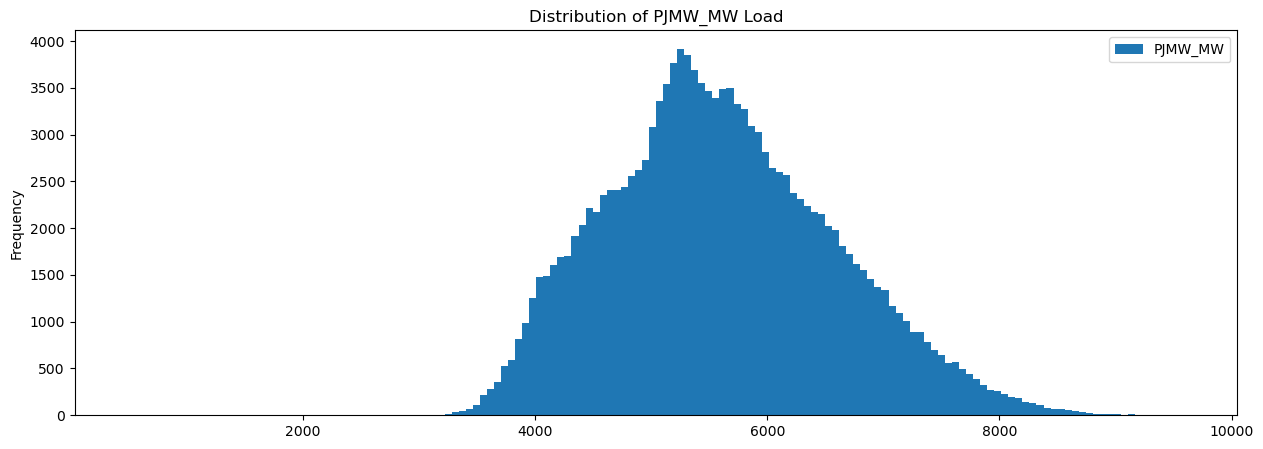

In [22]:
# Distribution of energy consumption across all the data
data.plot.hist(figsize=(15,5), bins=150, title='Distribution of PJMW_MW Load')

Text(0.5, 1.0, "Consommation d'énergie Load PJM 2002-2018")

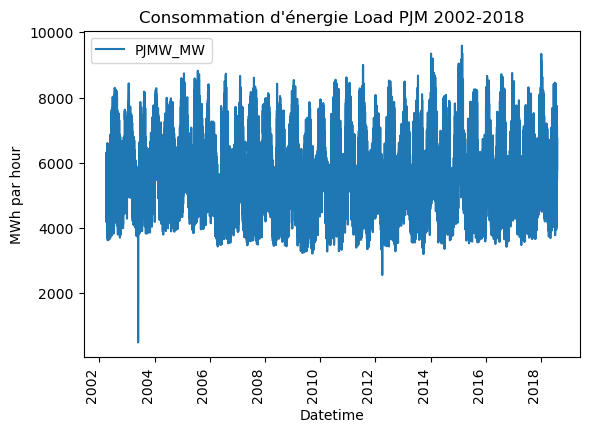

In [23]:
# Hourly Energy consumption across all years(2002-2018)
data.plot(rot=90)
plt.ylabel('MWh par hour')
plt.title('Consommation d\'énergie Load PJM 2002-2018')

# Visualisation par groupe

In [24]:
data['date'] = data.index.date
data['years'] = data.index.year
data['quarters'] = data.index.quarter
data['months'] = data.index.month
data['dom'] = data.index.day # dom=day of month
data['dow'] = data.index.dayofweek
data['doy'] = data.index.dayofyear
data['weekday'] = data.index.day_name()
data['woy'] = data.index.weekofyear
data['hour'] = data.index.hour
#data.tail()

C:\Users\saida\AppData\Local\Temp\ipykernel_123208\1507009463.py:9: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['woy'] = data.index.weekofyear


Text(0.5, 1.0, 'Energy consumption in day with boxplot')

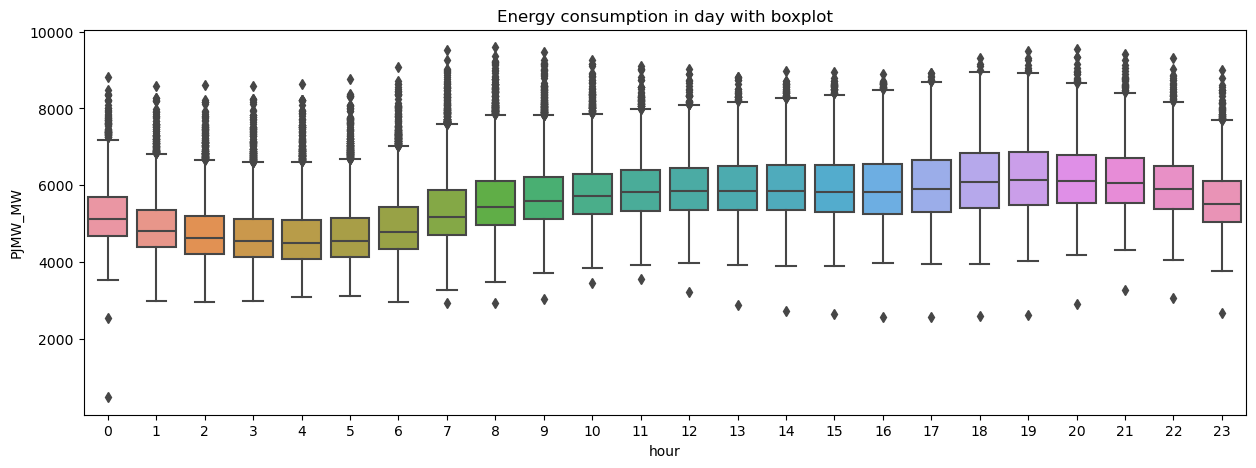

In [10]:
# day Energy consumption with boxplot
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x=data.hour, y=data.PJMW_MW)
ax.set_title('Energy consumption in day with boxplot')

Text(0.5, 1.0, 'Energy consumption in weekday with boxplot')

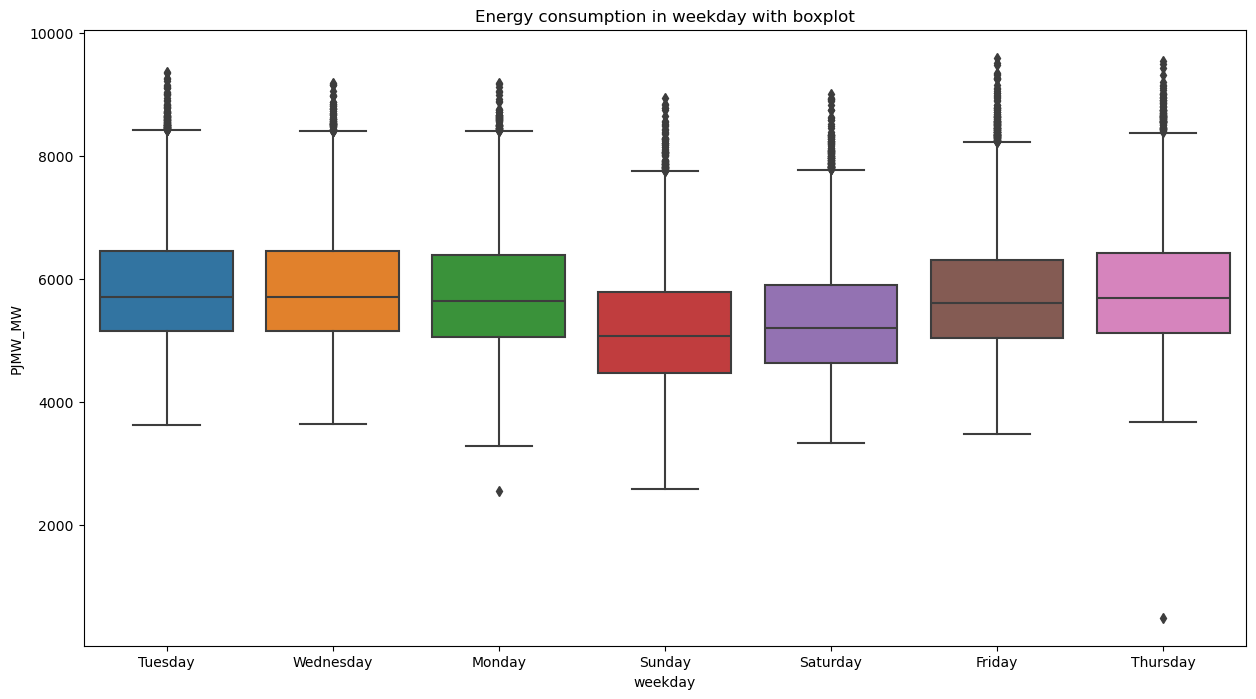

In [11]:
# weekday Energy consumption with boxplot
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(x=data.weekday, y=data.PJMW_MW)
ax.set_title('Energy consumption in weekday with boxplot')

Text(0.5, 1.0, 'months Energy consumption with boxplot')

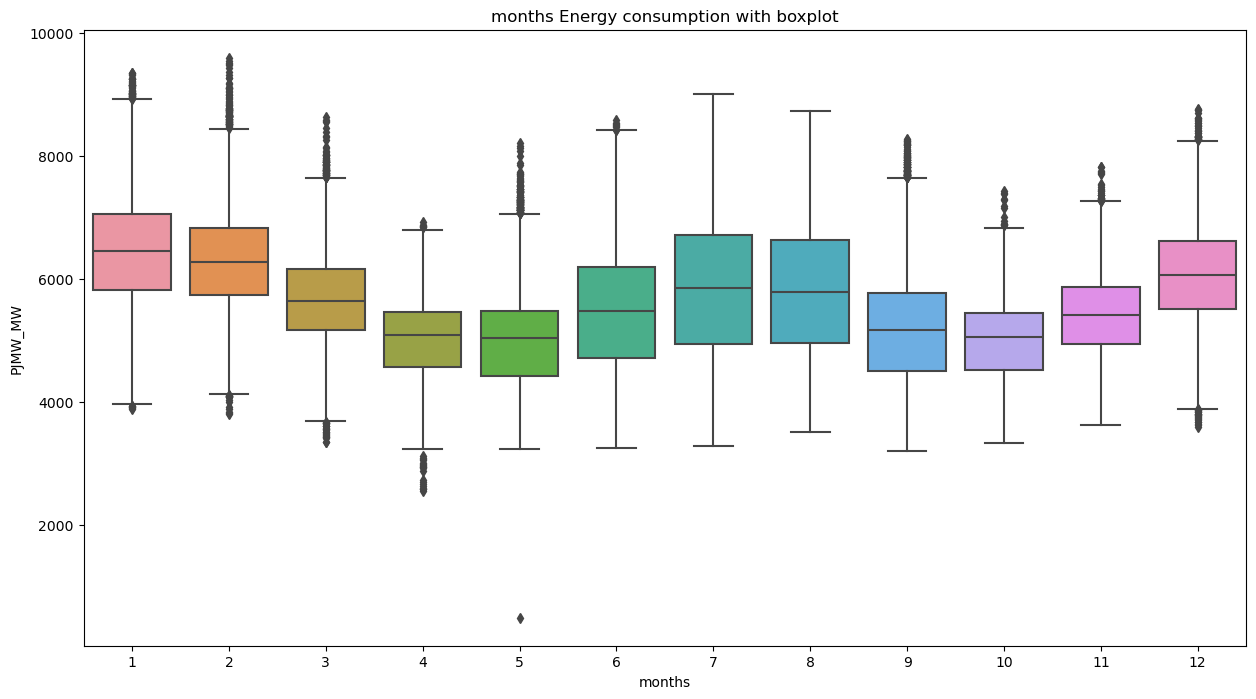

In [12]:
# month Energy consumption with boxplot
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(x=data.months, y=data.PJMW_MW)
ax.set_title('months Energy consumption with boxplot')

<Axes: title={'center': 'Energy consumption PJMW_MW in weekday '}, xlabel='hour'>

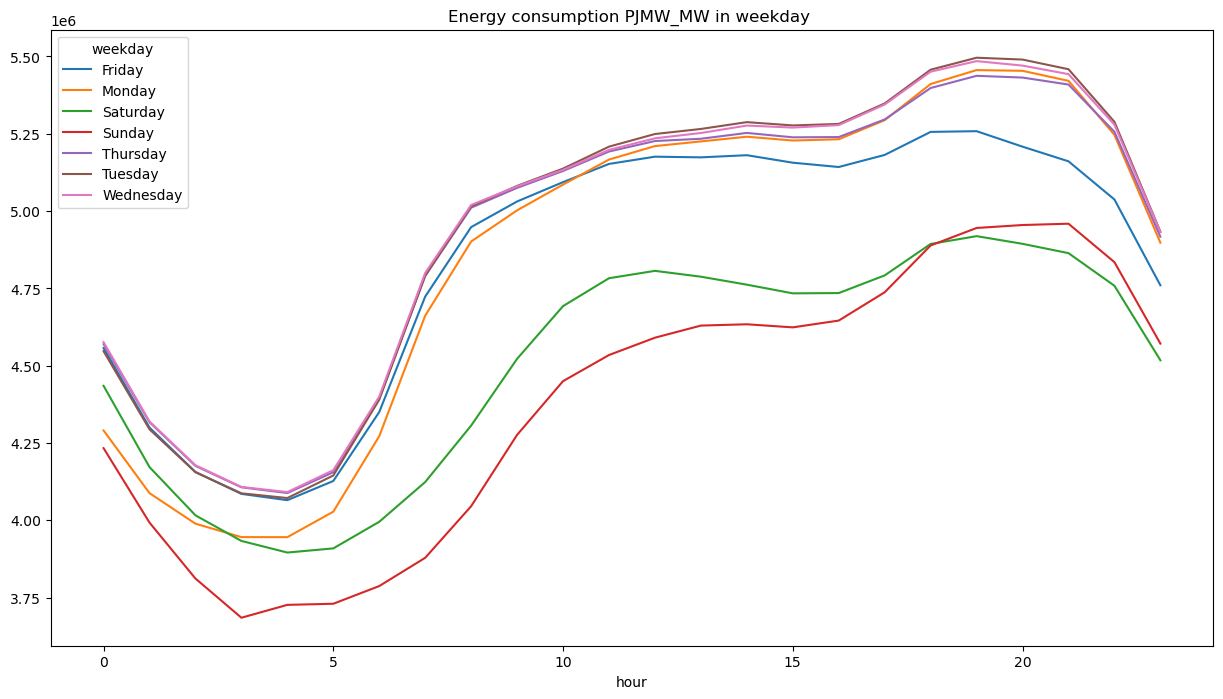

In [13]:
# Weekday and hour energy consumption 
## weekends behavior is different from weekday behavior --useful in modelling
data = data.pivot_table(index=data['hour'], columns='weekday', values='PJMW_MW', aggfunc='sum')
data.plot(figsize=(15,8), title='Energy consumption PJMW_MW in weekday ')

# Données calendaires en des signaux sinusoidaux 

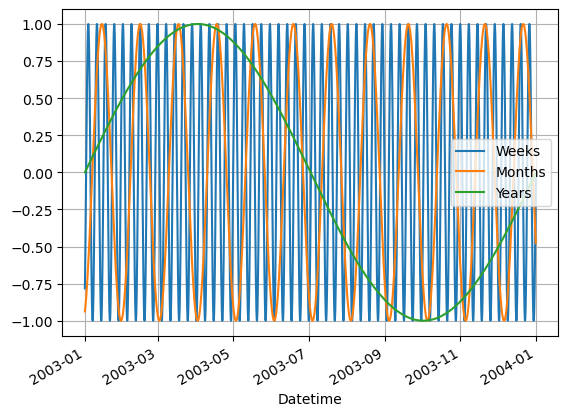

In [65]:
minutes = 60
hours = 12*60*minutes
day = 2*hours
weeks = 7*day
months = 31*day
years = (365.2425)*day
# Generate Unix timestamp for the datetime index
date_time = pd.to_datetime(data.index, format="%d/%m/%y %H:%M:%S")  # Convert nanoseconds to seconds

timestamp_s = date_time.map(pd.Timestamp.timestamp)

data["hours"] = np.sin(timestamp_s*(2*np.pi / hours))
data["days"] = np.sin(timestamp_s*(2*np.pi / day))
data["weeks"] = np.sin(timestamp_s*(2*np.pi / weeks))
data["months"] = np.sin(timestamp_s*(2*np.pi / months))
data["years"] = np.sin(timestamp_s*(2*np.pi / years))
#data["hours"][:24].plot(label="Hours", marker="x")
#data["days"][:24].plot(label="Days", marker="o")
data["weeks"]["2003-01-01":"2003-12-31"].plot(label="Weeks")
data["months"]["2003-01-01":"2003-12-31"].plot(label="Months")
data["years"]["2003-01-01":"2003-12-31"].plot(label="Years")
plt.grid()
plt.legend()

# Série temporelle univariée 

## Modèles : RNN, LSTM, GRU, ConvLSTM, Temporal Fusion Transformers

In [66]:
def create_sequence(dataframe, window_size, n_futur):
    X, y = [], []
    for i in range(window_size, len(df) - n_futur):
        X.append(dataframe.iloc[i - window_size:i])
        y.append(dataframe.iloc[i : i + n_futur, 0])
    X = np.array(X)
    y = np.array(y)
    print(X.shape)
    print(y.shape)
    return X, y

In [78]:
df.head()

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077.0
2002-12-31 02:00:00,4939.0
2002-12-31 03:00:00,4885.0
2002-12-31 04:00:00,4857.0
2002-12-31 05:00:00,4930.0


In [67]:
X, y = create_sequence(df, window_size=24, n_futur=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(143181, 24, 1)
(143181, 1)


((114544, 24, 1), (28637, 24, 1), (114544, 1), (28637, 1))

# RNN

In [79]:
model = Sequential()
model.add(SimpleRNN(units=128, activation="relu", return_sequences=True, input_shape=(24, 1)))
model.add(SimpleRNN(units=64, activation="relu", return_sequences = False))
model.add(Dense(units=1, activation='linear'))


model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 24, 128)           16640     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 29,057
Trainable params: 29,057
Non-trainable params: 0
_________________________________________________________________


In [80]:
history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
1790/1790 [==============================] - 32s 17ms/step - loss: 146.2251 - val_loss: 108.9296
Epoch 2/10
1790/1790 [==============================] - 22s 12ms/step - loss: 97.8789 - val_loss: 87.9856
Epoch 3/10
1790/1790 [==============================] - 39s 22ms/step - loss: 93.0457 - val_loss: 100.8750
Epoch 4/10
1790/1790 [==============================] - 32s 18ms/step - loss: 89.6812 - val_loss: 87.6443
Epoch 5/10
1790/1790 [==============================] - 32s 18ms/step - loss: 86.7897 - val_loss: 84.4023
Epoch 6/10
1790/1790 [==============================] - 30s 17ms/step - loss: 84.8476 - val_loss: 84.1152
Epoch 7/10
1790/1790 [==============================] - 34s 19ms/step - loss: 83.3351 - val_loss: 80.9454
Epoch 8/10
1790/1790 [==============================] - 30s 17ms/step - loss: 81.1905 - val_loss: 94.9311
Epoch 9/10
1790/1790 [==============================] - 22s 12ms/step - loss: 80.0600 - val_loss: 92.2208
Epoch 10/10
1790/1790 [====================

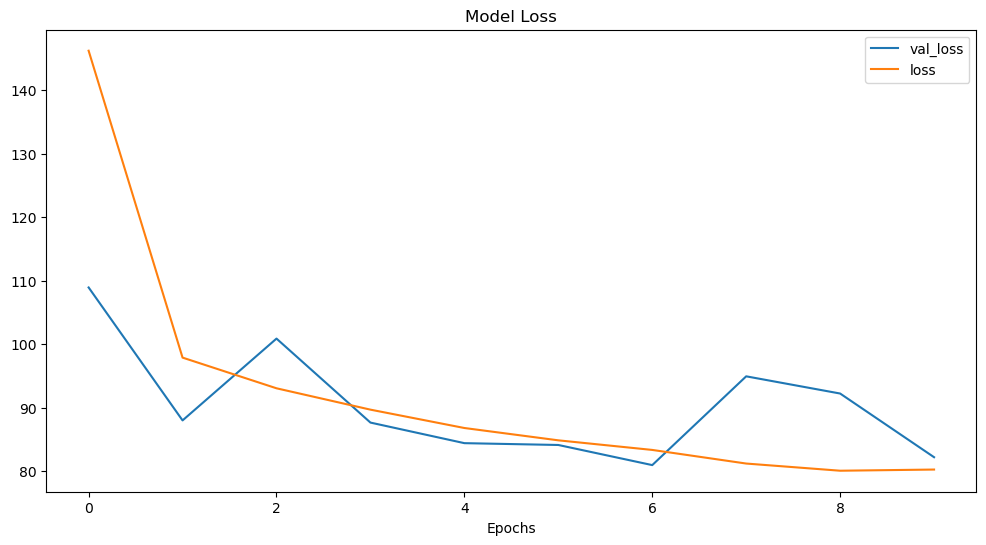

In [81]:
plt.figure(figsize=(12, 6))

plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["loss"], label="loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [82]:
y_pred =  model.predict(X_test)

895/895 [==============================] - 3s 3ms/step


In [83]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae, r2

(82.18850643534806, 0.9798319171061107)

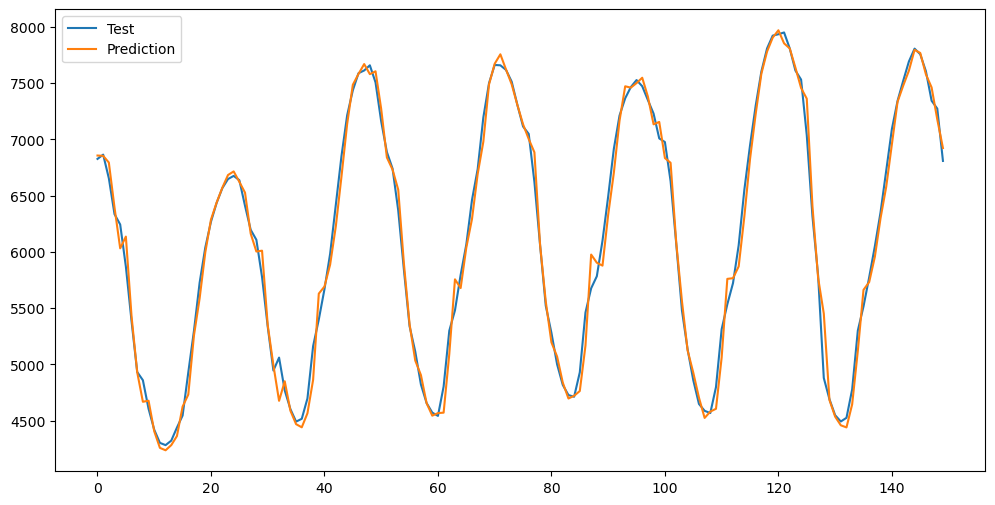

In [87]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(0, 150, 1), y_test[:150], label='Test')
plt.plot(np.arange(0, 150, 1), y_pred[:150], label='Prediction')
plt.legend()
plt.show()

# GRU

In [89]:
model_gru = Sequential()
model_gru.add(GRU(units=128, return_sequences=True, activation='relu', input_shape=(24, 1)))
model_gru.add(GRU(units=64, activation='relu', return_sequences=False))
model_gru.add(Dense(units=1, activation='linear'))


model_gru.compile(optimizer='adam', loss='mean_absolute_error')
model_gru.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
1790/1790 [==============================] - 52s 28ms/step - loss: 289.0934 - val_loss: 128.5306
Epoch 2/10
1790/1790 [==============================] - 58s 32ms/step - loss: 119.4334 - val_loss: 113.6584
Epoch 3/10
1790/1790 [==============================] - 78s 43ms/step - loss: 117.2653 - val_loss: 112.2840
Epoch 4/10
1790/1790 [==============================] - 82s 46ms/step - loss: 115.4242 - val_loss: 118.3048
Epoch 5/10
1790/1790 [==============================] - 73s 41ms/step - loss: 112.1989 - val_loss: 109.4510
Epoch 6/10
1790/1790 [==============================] - 43s 24ms/step - loss: 105.3567 - val_loss: 104.5811
Epoch 7/10
1790/1790 [==============================] - 40s 22ms/step - loss: 101.9677 - val_loss: 101.5762
Epoch 8/10
1790/1790 [==============================] - 39s 22ms/step - loss: 99.0569 - val_loss: 122.5061
Epoch 9/10
1790/1790 [==============================] - 42s 23ms/step - loss: 96.3800 - val_loss: 97.2071
Epoch 10/10
1790/1790 [========

In [94]:
y_pred_test = model_gru.predict(X_test)
err_test = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
err_test, r2

895/895 [==============================] - 6s 6ms/step


(106.2811524272985, 0.9714090540824303)

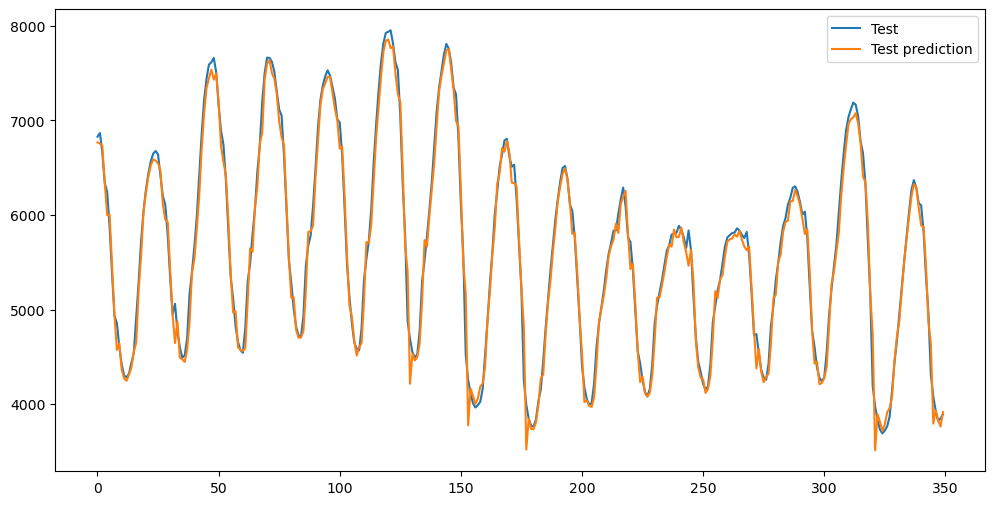

In [91]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(0, 350, 1), y_test[:350], label='Test')
plt.plot(np.arange(0, 350, 1), y_pred_test[:350], label='Test prediction')
plt.legend()
plt.show()

# LSTM

In [95]:
model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(24, 1)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1, activation="linear"))

model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [96]:
# Entrainement du modèle et prediction
history = model.fit(x=X_train, y=y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/10
3580/3580 [==============================] - 84s 23ms/step - loss: 742.9886 - val_loss: 382.3247
Epoch 2/10
3580/3580 [==============================] - 103s 29ms/step - loss: 626.5741 - val_loss: 436.4590
Epoch 3/10
3580/3580 [==============================] - 71s 20ms/step - loss: 419.6858 - val_loss: 363.0833
Epoch 4/10
3580/3580 [==============================] - 60s 17ms/step - loss: 391.7667 - val_loss: 436.3011
Epoch 5/10
3580/3580 [==============================] - 61s 17ms/step - loss: 303.6878 - val_loss: 265.9569
Epoch 6/10
3580/3580 [==============================] - 64s 18ms/step - loss: 201.1837 - val_loss: 140.8026
Epoch 7/10
3580/3580 [==============================] - 64s 18ms/step - loss: 136.8130 - val_loss: 185.3718
Epoch 8/10
3580/3580 [==============================] - 64s 18ms/step - loss: 147.4037 - val_loss: 123.4952
Epoch 9/10
3580/3580 [==============================] - 62s 17ms/step - loss: 117.1550 - val_loss: 107.5341
Epoch 10/10
3580/3580 [====

In [99]:
y_pred_test = model.predict(X_test)
err_test = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
err_test, r2

895/895 [==============================] - 5s 5ms/step


(104.81271122422478, 0.9748389902690584)

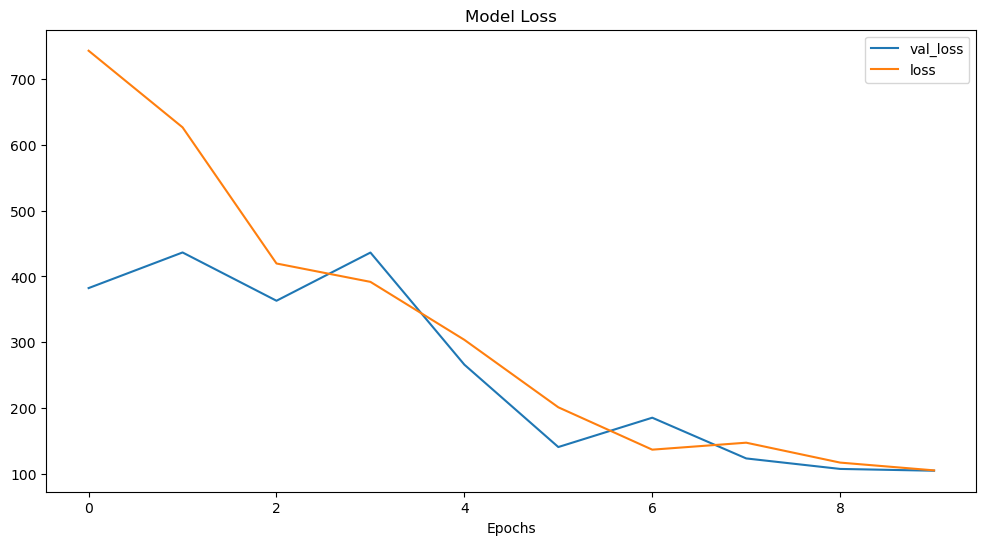

In [98]:
plt.figure(figsize=(12, 6))

plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["loss"], label="loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

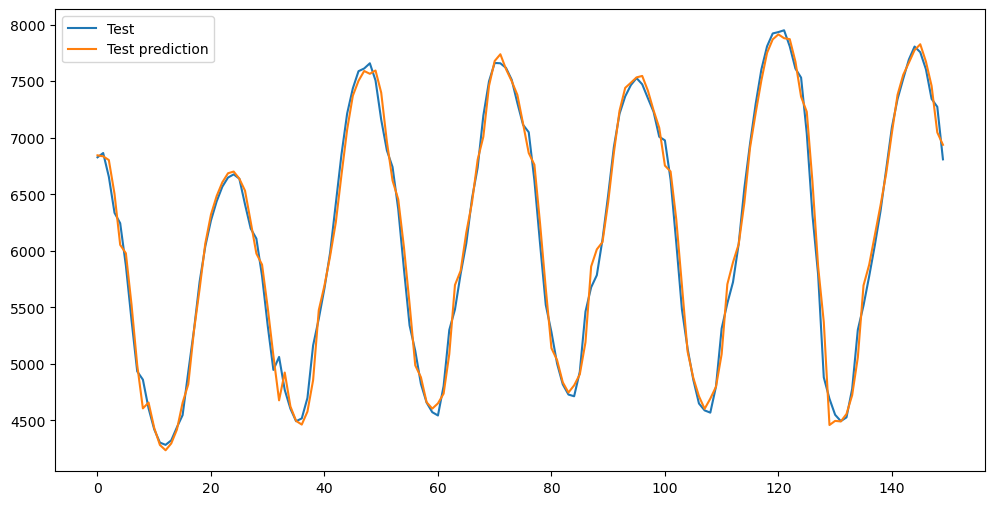

In [101]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(0, 150, 1), y_test[:150], label='Test')
plt.plot(np.arange(0, 150, 1), y_pred_test[:150], label='Test prediction')
plt.legend()
plt.show()

# ConvLSTM

In [103]:
model_convlstm = Sequential()
model_convlstm.add(Conv1D(64, kernel_size=3, strides=1, padding="same", input_shape=(24, 1)))
model_convlstm.add(Conv1D(64, kernel_size=3, strides=1, padding="same"))
model_convlstm.add(LSTM(64, activation="relu"))
model_convlstm.add(Dense(1, activation="linear"))

model_convlstm.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 64)            256       
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 64)            12352     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 45,697
Trainable params: 45,697
Non-trainable params: 0
_________________________________________________________________


In [104]:
model_convlstm.compile(optimizer="adam", loss="mae")
model_convlstm.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
3580/3580 [==============================] - 38s 10ms/step - loss: 399.3749 - val_loss: 220.8867
Epoch 2/10
3580/3580 [==============================] - 63s 18ms/step - loss: 506.9542 - val_loss: 172.6613
Epoch 3/10
3580/3580 [==============================] - 65s 18ms/step - loss: 164.9359 - val_loss: 141.3327
Epoch 4/10
3580/3580 [==============================] - 62s 17ms/step - loss: 140.2628 - val_loss: 133.0726
Epoch 5/10
3580/3580 [==============================] - 59s 16ms/step - loss: 124.4321 - val_loss: 109.3888
Epoch 6/10
3580/3580 [==============================] - 50s 14ms/step - loss: 122.3586 - val_loss: 105.5966
Epoch 7/10
3580/3580 [==============================] - 65s 18ms/step - loss: 338.1989 - val_loss: 276.4149
Epoch 8/10
3580/3580 [==============================] - 50s 14ms/step - loss: 240.6629 - val_loss: 210.2574
Epoch 9/10
3580/3580 [==============================] - 64s 18ms/step - loss: 157.5954 - val_loss: 123.7354
Epoch 10/10
3580/3580 [=====

In [106]:
y_pred_test = model_convlstm.predict(X_test)
err_test = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
err_test, r2

895/895 [==============================] - 3s 3ms/step


(122.67388674534911, 0.9658201281175814)

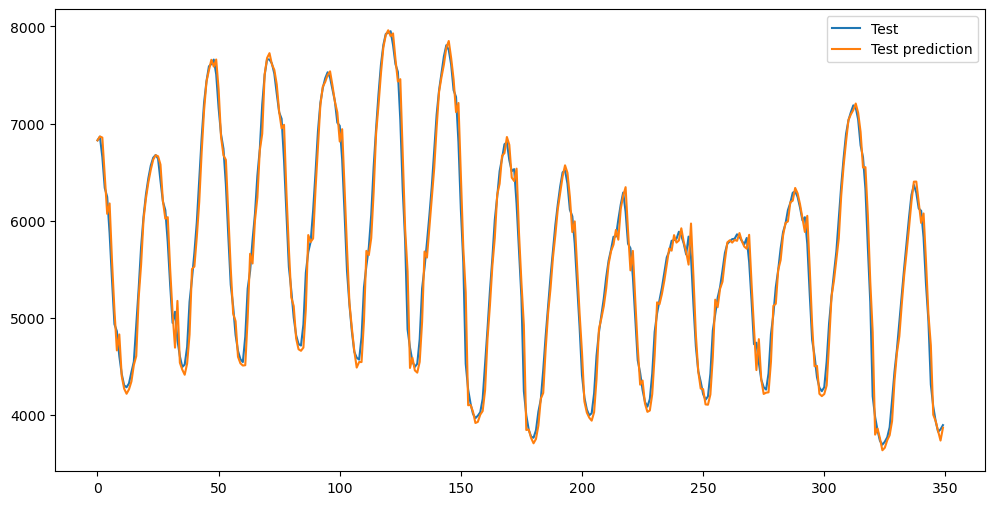

In [107]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(0, 350, 1), y_test[:350], label='Test')
plt.plot(np.arange(0, 350, 1), y_pred_test[:350], label='Test prediction')
plt.legend()
plt.show()

# Prédiction MultiHorizon(6 heures c'est-à-dire 6 points)

In [109]:
X_moyen, y_moyen = create_sequence(df, window_size=24, n_futur=6)

(143176, 24, 1)
(143176, 6)


In [122]:
X_training, X_testing, y_training, y_testing = train_test_split(X_moyen, y_moyen, test_size=0.2, random_state=0, shuffle=False)
X_training.shape, X_testing.shape, y_training.shape, y_testing.shape

((114540, 24, 1), (28636, 24, 1), (114540, 6), (28636, 6))

In [142]:
model = Sequential()
model.add(SimpleRNN(128, activation="relu", return_sequences=True, input_shape=(24, 1)))
model.add(SimpleRNN(128, activation="relu", return_sequences=True))
#model.add(LSTM(64, activation="relu", return_sequences=True))
model.add(SimpleRNN(64, activation="relu"))
model.add(Dense(6, "linear"))

model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 24, 128)           16640     
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 24, 128)           32896     
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 64)                12352     
                                                                 
 dense_11 (Dense)            (None, 6)                 390       
                                                                 
Total params: 62,278
Trainable params: 62,278
Non-trainable params: 0
_________________________________________________________________


In [143]:
model.compile(optimizer="adam", loss="mae")
model.fit(x=X_training, y=y_training, validation_data=(X_testing, y_testing), epochs=10, batch_size=128)

Epoch 1/10
895/895 [==============================] - 30s 32ms/step - loss: 341.7738 - val_loss: 218.4673
Epoch 2/10
895/895 [==============================] - 31s 35ms/step - loss: 209.6419 - val_loss: 231.5324
Epoch 3/10
895/895 [==============================] - 22s 24ms/step - loss: 199.6624 - val_loss: 220.9351
Epoch 4/10
895/895 [==============================] - 42s 47ms/step - loss: 189.6150 - val_loss: 219.7869
Epoch 5/10
895/895 [==============================] - 24s 27ms/step - loss: 187.1190 - val_loss: 230.4537
Epoch 6/10
895/895 [==============================] - 42s 47ms/step - loss: 179.9538 - val_loss: 191.1045
Epoch 7/10
895/895 [==============================] - 26s 29ms/step - loss: 178.8998 - val_loss: 189.5156
Epoch 8/10
895/895 [==============================] - 35s 39ms/step - loss: 172.3338 - val_loss: 197.5672
Epoch 9/10
895/895 [==============================] - 35s 39ms/step - loss: 174.8824 - val_loss: 191.7468
Epoch 10/10
895/895 [=========================

In [144]:
y_pred_train, y_pred_test = model.predict(X_training), model.predict(X_testing)
err_train, err_test = mean_absolute_error(y_training, y_pred_train), mean_absolute_error(y_testing, y_pred_test)
r2 = r2_score(y_testing, y_pred_test)
err_train, err_test, r2

895/895 [==============================] - 12s 14ms/step


(184.5234184526688, 209.11452454326596, 0.9146234417228022)

In [145]:
pred = y_pred_test[::6, :]
pred = pred.reshape(-1, 1)

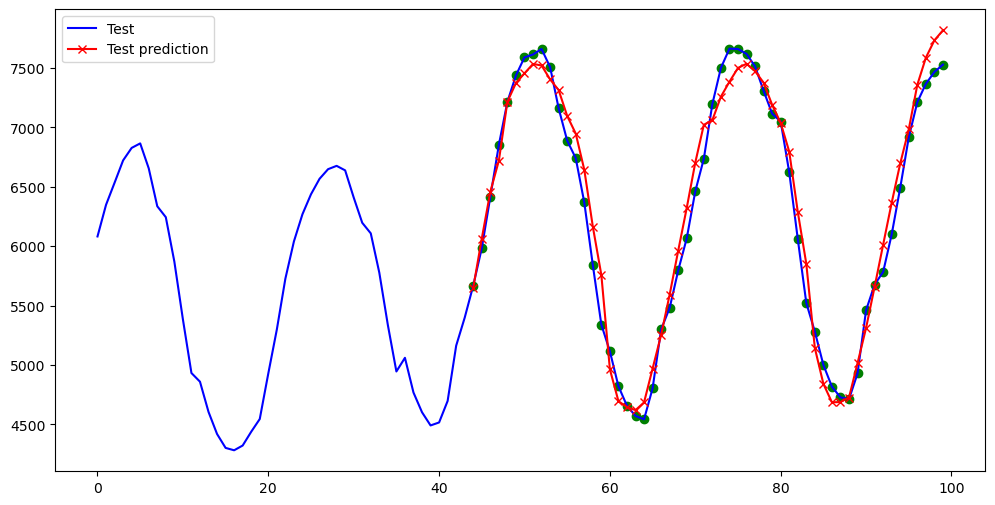

In [148]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(0, 100, 1), y_testing[:100, 0], label='Test', c="b")
plt.scatter(np.arange(44, 100, 1), y_testing[44:100, 0], c="green")
plt.plot(np.arange(44, 100, 1), pred[44:100], label='Test prediction', marker="x", c="r")
plt.legend()
plt.show()

# Temporal Fusion Transformers

In [152]:
import keras
inputs = keras.layers.Input(shape=(X_training.shape[1], X_training.shape[2]), name='inputs')
 

Conv1D_tar1 = keras.layers.Conv1D(5, 3, 1, activation='relu', padding='same', name='Conv1D_tar1')(inputs)
Dropout1 = keras.layers.Dropout(0.2, name='Dropout1')(Conv1D_tar1)
 
Conv1D_tar2 = keras.layers.Conv1D(5, 3, 2, activation='relu', padding='same', name='Conv1D_tar2')(Dropout1)
Dropout2 = keras.layers.Dropout(0.2, name='Dropout2')(Conv1D_tar2)
 
Conv1D_tar3 = keras.layers.Conv1D(5, 3, 4, activation='relu', padding='same', name='Conv1D_tar3')(Dropout2)
Dropout3 = keras.layers.Dropout(0.2, name='Dropout3')(Conv1D_tar3)
 
Conv1D1 = keras.layers.Conv1D(5, 3, 1, activation='relu', padding='same', name='Conv1D1')(inputs)
Conv1D2 = keras.layers.Conv1D(5, 3, 1, activation='relu', padding='same', name='Conv1D2')(Conv1D1)


merged_Conv1D = keras.layers.Concatenate(name='merged_Conv1D', axis=1)([Conv1D2, Dropout3])
 
Flatten = keras.layers.Flatten(name='Flatten')(merged_Conv1D)

dense_tar1 = keras.layers.Dense(64, activation='relu', name='dense_tar1')(Flatten)
dense_tar2 = keras.layers.Dense(24, activation='relu', name='dense_tar2')(dense_tar1)
outputs_tar = keras.layers.Dense(6, activation='relu', name='outputs_tar')(dense_tar2)
 
model = keras.Model(inputs=inputs, outputs=outputs_tar)

In [153]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 24, 1)]      0           []                               
                                                                                                  
 Conv1D_tar1 (Conv1D)           (None, 24, 5)        20          ['inputs[0][0]']                 
                                                                                                  
 Dropout1 (Dropout)             (None, 24, 5)        0           ['Conv1D_tar1[0][0]']            
                                                                                                  
 Conv1D_tar2 (Conv1D)           (None, 12, 5)        80          ['Dropout1[0][0]']               
                                                                                            

In [154]:
model.compile(optimizer="adam", loss="mae")

In [155]:
model.fit(X_training, y_training, epochs=10, validation_data=(X_testing, y_testing), batch_size=128)

Epoch 1/10
895/895 [==============================] - 103s 115ms/step - loss: 375.9214 - val_loss: 237.5249
Epoch 2/10
895/895 [==============================] - 99s 110ms/step - loss: 214.2147 - val_loss: 218.8275
Epoch 3/10
895/895 [==============================] - 100s 112ms/step - loss: 199.6326 - val_loss: 213.2255
Epoch 4/10
895/895 [==============================] - 105s 117ms/step - loss: 191.4963 - val_loss: 209.4253
Epoch 5/10
895/895 [==============================] - 100s 112ms/step - loss: 188.8903 - val_loss: 203.4406
Epoch 6/10
895/895 [==============================] - 100s 112ms/step - loss: 186.1858 - val_loss: 202.2472
Epoch 7/10
895/895 [==============================] - 102s 114ms/step - loss: 184.3798 - val_loss: 202.0427
Epoch 8/10
895/895 [==============================] - 102s 114ms/step - loss: 182.4896 - val_loss: 197.6540
Epoch 9/10
895/895 [==============================] - 100s 112ms/step - loss: 180.2280 - val_loss: 195.0547
Epoch 10/10
895/895 [========

In [156]:
pred = model.predict(X_testing)

895/895 [==============================] - 1s 883us/step


In [157]:
r2 = r2_score(y_testing, pred)
mae = mean_absolute_error(y_testing, pred)
mae, r2

(208.0690706987235, 0.9163432188605029)

In [158]:
pred = y_pred_test[::6, :]
pred = pred.reshape(-1, 1)

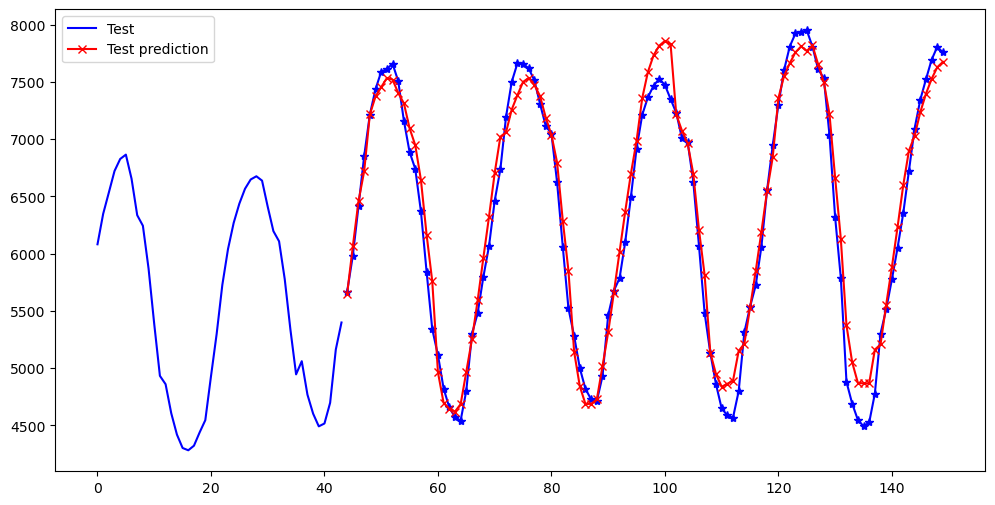

In [161]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(0, 44, 1), y_test[:44, 0], label='Test', c="b")
plt.plot(np.arange(44, 150, 1), y_test[44:150, 0], marker="*", c="b")
plt.plot(np.arange(44, 150, 1), pred[44:150], label='Test prediction', marker="x", c="r")
plt.legend()
plt.show()